In [13]:
import os
import pickle
import shutil 
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import math
from IPython import embed

In [14]:
# set up simulation constants

rresolution =30

n_air = 1.0000003
n_Si = 1.45
n_SiO2 = 3.48

a = 0.5   # lattice period 

#pml_thickness = round(wavelength / 2,3)
pml_thickness = 0.780
height_hole = 5
height_SiO2 = height_hole
height_air = 7+2*pml_thickness
height_Si_initial= 0.5*(height_air-height_hole)
height_Si_add = 0.75*0.5*height_SiO2


cell_x = a
cell_y = a
cell_z = height_air

z_air = height_air

center_air = 0 
center_SiO2 = 0 
center_hole = 0
center_Si_initial = -0.5*height_hole -0.25*(height_air-height_hole)+0.005
center_Si_add = 0.5*height_Si_add

In [15]:

#initial_geometry setup

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_air), 
                    center=mp.Vector3(0,0,center_air),
                    material=mp.Medium(index=n_air)),
           mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_Si_initial),
                   center=mp.Vector3(0,0,center_Si_initial),
                   material=mp.Medium(index=n_Si))]


k_point = mp.Vector3(0,0,0)

## source ##
center_source = -0.5*height_hole-0.125*(height_air-height_hole) 
source_cmpt = mp.Ey

wavelength = 1.55
freq = 1 / wavelength


sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]


## flux monitor ##
nfreq = 1
df = 0
fr_center = 0.5*height_hole+0.125*(height_air-height_hole)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))



if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]




In [16]:
sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)
flux_object = sim.add_flux(freq, df, nfreq, fr)


sim.run(until=200)


combined_initial_flux = mp.get_fluxes(flux_object)[0]



# In[4]:


geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_SiO2), 
                    center=mp.Vector3(0,0,center_SiO2),
                    material=mp.Medium(index=n_SiO2)))

geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_Si_add), 
                    center=mp.Vector3(0,0,center_Si_add),
                    material=mp.Medium(index=n_Si)))


## initialize matrix for data collection ##
##########################################

num_holes = 15  # this is the number of pillars we will build
num_height = 15
min_r = 0.1
max_r = 0.245
min_h = 1.02
max_h = 5
data = np.zeros((4,num_holes))






-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00238895 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 8.55 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1e+20,8.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-3.385)
          size (1e+20,1e+20,1.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
time for set_epsilon = 0.0541668 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)


In [5]:
sim.reset_meep()

combined_data = {}
height_list = []

def run_sim(radius,height,sim) :
    print(radius)
    
    geometry.append(mp.Cylinder(radius=radius,
                        height=height,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_hole),
                        material=mp.Medium(index=n_air)))
                
                
    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)
                    #save_geometry(sim, radius, height)
                        
    flux_object = sim.add_flux(freq, df, nfreq, fr)  
    sim.run(until=200)
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 

    if phase<-np.pi:
        phase = phase +2*np.pi
    elif phase>-np.pi and phase<np.pi:
        phase = phase
    else:
        phase = phase - 2*np.pi
                                                    
   #radii_list.append(radius)
   # flux_list.append(flux)
   # phase_list.append(phase)
   # new_heightlist.append(height)
                                                                        
    
    sim.reset_meep()
    geometry.pop(-1)

    return phase, flux

def save_geometry(sim, radius, height):
    fig = plt.figure(figsize=(10,10))
    sim.plot2D(output_plane=plot_plane)

pbar = tqdm(total=num_height*num_holes,leave=False)
new_heightlist =[]
for h, height in enumerate(np.linspace(min_h,max_h,num_height)):
    radii_list=[] 
    flux_list, phase_list=[],[]
    new_heightlist.append(height)
    for r, radius in enumerate(np.linspace(min_r,max_r,num_holes)):
        radii_list.append(radius)
        phase, flux=run_sim(radius,height,sim)
        phase_list.append(phase)
        flux_list.append(flux)
        
        print(h,r)
        print("#########################################")
        print(f"phase: {phase} flux: {flux} radis:{radius} depth:{height}")
        pbar.update(1)
    combined_data[h] = {
            'height' : height,
            'flux' : flux_list,
            'phase' : phase_list,
            'radii' : radii_list,
            'new_height' : new_heightlist 
             }
       
pbar.close()

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000627995 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0315959 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


0.0
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00105095 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0302 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.017499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000682831 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.0175, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.03125 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.034999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00128293 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.035, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0331619 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.05249999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000745058 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.0525, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.043268 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.06999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00158691 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.07, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0435822 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.0875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000882149 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.0875, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.044399 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.10499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000880957 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.105, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.042794 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.12249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00250196 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.1225, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0426979 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.13999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000916004 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.14, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.04579 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.15749999999999997
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000880957 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.1575, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0473802 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.175
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000727177 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.175, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.046345 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.19249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00110698 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.1925, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.047986 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.20999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00176096 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.21, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.053323 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.22749999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000841856 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.2275, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.049973 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.245
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000888109 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.245, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.045244 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.0
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00126004 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0281138 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.017499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000642061 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.0175, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0293179 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.034999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000617981 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.035, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0371671 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.05249999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00115585 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.0525, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0634458 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.06999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00134182 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.07, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0625091 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.0875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000776052 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.0875, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0642252 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.10499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000735998 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.105, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0659301 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.12249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000798941 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.1225, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.062295 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.13999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000772953 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.14, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.066365 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.15749999999999997
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00123787 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.1575, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0698471 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.175
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000829935 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.175, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0647588 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.19249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000782013 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.1925, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.077462 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.20999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000833988 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.21, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0836971 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.22749999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000723839 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.2275, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.084295 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.245
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00109386 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.245, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.068718 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.0
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00087595 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.028301 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.017499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000968933 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.0175, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0320129 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.034999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0012331 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.035, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.047328 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.05249999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000879049 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.0525, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0939291 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.06999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000760078 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.07, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0862651 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.0875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00159788 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.0875, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0946269 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.10499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000735998 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.105, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0916731 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.12249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000862122 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.1225, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.093534 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.13999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000766039 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.14, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0910189 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.15749999999999997
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000833988 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.1575, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0969238 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.175
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000886917 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.175, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0880849 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.19249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000813961 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.1925, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.109184 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.20999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00148821 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.21, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.115473 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.22749999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000773191 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.2275, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.115645 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.245
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00097394 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.245, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0928838 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


In [74]:
import pickle
combined_data = pickle.load(open("/develop/results/combined_data.pkl", "rb"))
combined_initial_flux = pickle.load(open("/develop/results/combined_initial_flux.pkl","rb"))

In [33]:
# print(combined_data)
# print(combined_initial_flux)

In [34]:
## pickle operations

for k,j in enumerate(np.linspace(0,num_height-1,num_height)):
    for v,l in enumerate(np.linspace(0,num_holes-1, num_holes)):
        x=combined_data[k]['radii']
        y=combined_data[k]['new_height']
        z=combined_data[k]['phase']
        z_1=combined_data[k]['flux']

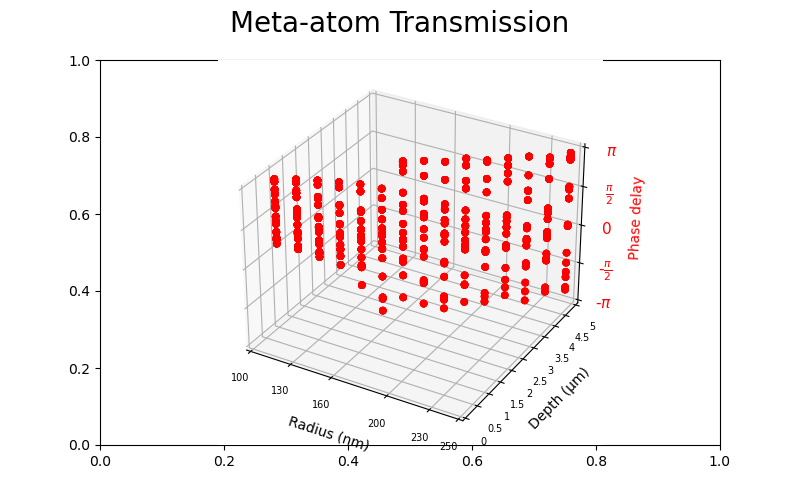

In [37]:
plt.close('all')
# #plt.style.use('seaborn')
# %matplotlib inline
# results = {"radii": radii_list, "height" : height_list, "flux": flux_list, "phase": phase_list}
# # this section plots radius vs. phas and transmission

tickfontsize=7
labelfontsize=10
titlefontsize=20

# #bring back code here!!

fig,ax = plt.subplots(figsize=(8,5))
ax = fig.add_subplot(projection='3d')
fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

# x axis
ax.set_xlim(0.1, 0.250)
ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.1,0.13,0.16,0.2,0.23,0.250])
ax.set_xticklabels([100, 130,160,200,230,250],fontsize=tickfontsize)

# y axis
ax.set_ylim(0, 1)
ax.set_ylabel("Depth (µm)",fontsize=labelfontsize)
ax.set_yticks([0 ,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax.set_yticklabels([0 ,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],fontsize=tickfontsize)


# z axis - phase
ax.set_zlim(-np.pi,np.pi)
ax.set_zlabel(r'Phase delay',fontsize=labelfontsize, color = 'red')
ax.set_zticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
ax.set_zticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
ax.tick_params(axis='z', labelcolor = 'red')


# #ax.plot(combined_data[:][radii_list], combined_data[:][flux_list], combined_data[:][height_list], 'b', label='Transmission')

for k,j in enumerate(np.linspace(0,num_height-1,num_height)):
    for v,l in enumerate(np.linspace(0,num_holes-1,num_holes)):
        # combined_data[][]
        x = combined_data[k]['radii']
        y = combined_data[k]['new_height']
        z = combined_data[k]['phase']
        z_1 = combined_data[k]['flux']

#         print(x)
#         print(y)
#         print(z)2866974, -1.0394119867350093, 0.5868561615887135]

#         print(z_1)
#         print("~~")cd code

        ax.scatter(x,y,z, color='red')

        # ax.plot_surface(combined_data[k]['radii'][k], combined_data[k]['phase'][k], combined_data[k]['height'], cmap=plt.cm.YlGnBu_r)

plt.grid(False)
plt.show()
 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



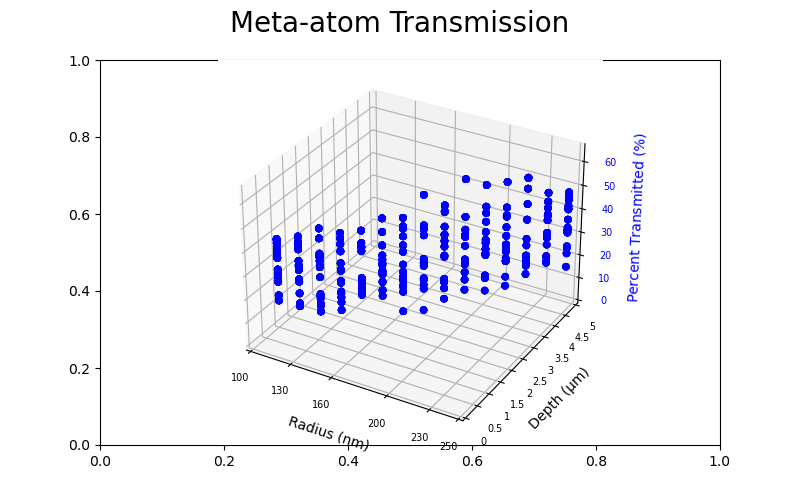

In [47]:

# #plt.style.use('seaborn')
# %matplotlib inline
# results = {"radii": radii_list, "height" : height_list, "flux": flux_list, "phase": phase_list}
# # this section plots radius vs. phas and transmission

tickfontsize=7
labelfontsize=10
titlefontsize=20

# #bring back code here!!

fig,ax = plt.subplots(figsize=(8,5))
ax = fig.add_subplot(projection='3d')
fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

ax.set_xlim(0.1, 0.250)
ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.1,0.13,0.16,0.2,0.23,0.250])
ax.set_xticklabels([100, 130,160,200,230,250],fontsize=tickfontsize)

# y axis
ax.set_ylim(0, 1)
ax.set_ylabel("Depth (µm)",fontsize=labelfontsize)
ax.set_yticks([0 ,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax.set_yticklabels([0 ,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],fontsize=tickfontsize)


# z axis - phase
ax.set_zlim(0,66)
ax.set_zlabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
ax.set_zticks([0,10,20,30,40,50, 60])
ax.set_zticklabels([0,10,20,30,40,50, 60],fontsize=tickfontsize)
ax.tick_params(axis='z', labelcolor = 'blue')



# #ax.plot(combined_data[:][radii_list], combined_data[:][flux_list], combined_data[:][height_list], 'b', label='Transmission')

for k,j in enumerate(np.linspace(0,num_height-1,num_height)):
    for v,l in enumerate(np.linspace(0,num_holes-1,num_holes)):
        # combined_data[][]
        x = combined_data[k]['radii']
        y = combined_data[k]['new_height']
        z = combined_data[k]['phase']
        z_1 = combined_data[k]['flux']

        print(combined_data)

#         print(x)
#         print(y)
#         print(z)2866974, -1.0394119867350093, 0.5868561615887135]

#         print(z_1)
#         print("~~")

        ax.scatter(x,y,z_1, 'o-', color='blue')
        # ax.plot_surface(combined_data[k]['radii'][k], combined_data[k]['phase'][k], combined_data[k]['height'], cmap=plt.cm.YlGnBu_r)

plt.grid(False)
plt.show()
 

In [70]:
transmission = []
x = []
y = []
phases = []


for k,j in enumerate(np.linspace(0,num_height-1,15)):
    y.append(combined_data[k]['height'])
    # combined_data[][]
    x.append(combined_data[k]['radii'])
    #y.append(combined_data[k]['new_height'])
    phases.append(combined_data[k]['phase'])
    transmission.append(combined_data[k]['flux'])

    
#x = x[0]
x = np.asarray(x[0])
y = np.asarray(y)
phases = np.asarray(phases)
transmission = np.asarray(transmission)

In [71]:
print(phases)

[[ 2.74970571e+00  2.67221820e+00  2.56575177e+00  2.43249908e+00
   2.28131171e+00  2.04441487e+00  1.81552764e+00  1.50644016e+00
   1.21707105e+00  8.99020596e-01  6.14739827e-01  3.28368365e-01
  -3.94653715e-02 -5.14593163e-01 -1.19399479e+00]
 [ 2.64910416e+00  2.54488095e+00  2.39808185e+00  2.22645676e+00
   1.99837417e+00  1.66673815e+00  1.33023830e+00  9.01396174e-01
   5.77598355e-01  2.69183228e-01  4.99432226e-02 -1.91339456e-01
  -5.66547441e-01 -1.44816981e+00 -2.75397839e+00]
 [ 2.33536063e+00  2.23555070e+00  1.91618792e+00  1.53164424e+00
   1.24305861e+00  1.19916188e+00  1.08257379e+00  7.56599548e-01
   4.38591195e-01  4.68635662e-04 -3.49597169e-01 -6.66661590e-01
  -1.48719829e+00 -2.58427885e+00  2.66890402e+00]
 [ 2.34017311e+00  2.13266665e+00  1.84498122e+00  1.50740691e+00
   1.18275423e+00  8.13903025e-01  5.62067138e-01  2.75628443e-01
   3.06606745e-02 -3.18464522e-01 -8.00969455e-01 -1.61346930e+00
  -2.67976933e+00  2.75637166e+00  1.52276328e+00]
 [ 2

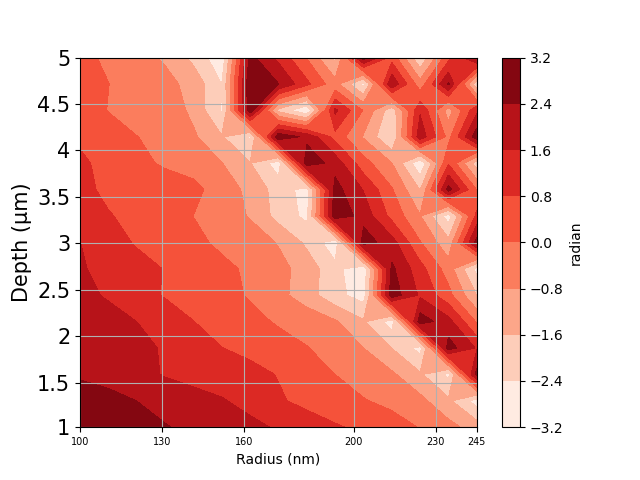

In [72]:
plt.close('all')
[X, Y] = np.meshgrid(x, y)
# plt.style.use('seaborn-v0_8')
#ax.contour(X, Y, phases)
fig,ax = plt.subplots(1,1)
cm= ax.contourf(X,Y,phases, cmap = 'Reds')

ax.set_xlim(0.1, 0.245)
ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.1,0.13,0.16,0.2,0.23,0.245])
ax.set_xticklabels([100, 130,160,200,230,245],fontsize=tickfontsize)

ax.set_ylim(1.02, 5)
ax.set_ylabel("Depth (µm)",fontsize=15)
ax.set_yticks([1.02, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax.set_yticklabels([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],fontsize=15)


cbar = fig.colorbar(cm,ax=ax)
cbar.set_label('radian')
# plt.imshow(phases, cmap = 'turbo')
# plt.colorbar(label = 'my unit')
ax.grid(True)
plt.show()

In [80]:
print(phases.shape)
print(phases.dtype)

(15, 15)
float64


1.02
0.245


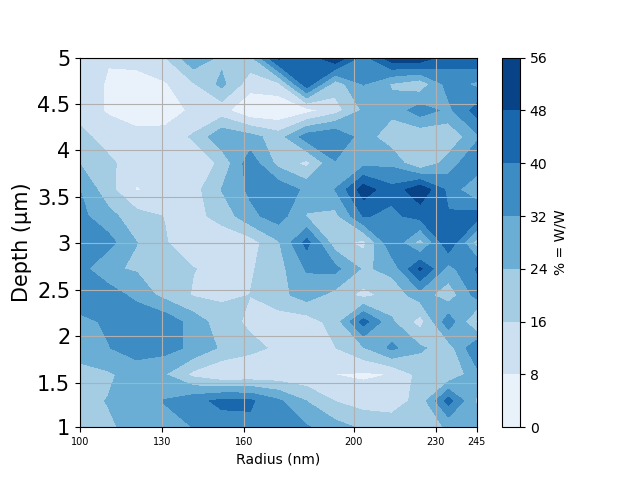

In [73]:
plt.close('all')
#plt.style.use('seaborn-v0_8')
[X, Y] = np.meshgrid(x, y)
#ax.contour(X, Y, phases)
fig,ax = plt.subplots(1,1)
cm = ax.contourf(X,Y,transmission, cmap = 'Blues')

ax.set_xlim(0.1, 0.245)
ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.1,0.13,0.16,0.2,0.23,0.245])
ax.set_xticklabels([100, 130,160,200,230,245],fontsize=tickfontsize)

ax.set_ylim(1.02, 5)
ax.set_ylabel("Depth (µm)",fontsize=15)
ax.set_yticks([1.02, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax.set_yticklabels([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],fontsize=15)
print(y.min())

print(x.max())
ax.grid(True)S
cbar1=fig.colorbar(cm,ax=ax)
cbar1.set_label('% = W/W')
#plt.colorbar(label='% = W/W')

plt.show()

